# Introduction

I am a physician and I am studying medical AI and data science. This time I tried object detection in chest X-ray images. There are 8 types of clinical findings, such as infiltration, atelectasis, effusion, mass, nodule, cardiomegaly, etc. Particularly, detection of mass and nodule is clinically very important, because mass or nodule on a chest X-ray image suggests possibility of lung cancer. In many cases, patients having lung cancer have no symptoms at an early stage. Thus, mass or nodule is found by coincidence on a chest X-ray image and lung cancer is suspected. Then, the final diagnosis is often made with CT. Therefore, mass or nodule must not be overlooked, and AI is expected to support physicians or radiologists with finding mass or nodule without fail.

**This object detection data is shown in csv file.** You can see object detection data **in json file** at [Arthropod Taxonomy Orders Object Detection (JSON)](https://www.kaggle.com/code/gokifujiya/arthropod-taxonomy-orders-object-detection-json), and **in xml file** at [Face Mask Object Detection with XML File](https://www.kaggle.com/code/gokifujiya/face-mask-object-detection-with-xml-file).

# Import Libraries and Upload CSV File

First, import necessary libraries and the csv file to describe all the chest X-ray images in the dataset. Please note that **they are generally made for the classification task purpose, and only some of them have information for object detection tasks (bounding box)**.

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
all_xray_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_xray_df.sample(5)

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
3794    00001034_005.png     No Finding            5        1034           73   
60473   00014933_002.png     No Finding            2       14933           55   
50352   00012746_002.png       Effusion            2       12746           47   
25430   00006695_003.png    Atelectasis            3        6695           62   
110006  00029939_000.png     No Finding            0       29939           11   

       Patient Gender View Position  OriginalImage[Width  Height]  \
3794                M            AP                 2500     2048   
60473               F            AP                 2500     2048   
50352               F            PA                 2992     2991   
25430               F            AP                 2500     2048   
110006              F            AP                 3056     2544   

        OriginalImagePixelSpacing[x     y]  Unnamed: 11  
3794                          0.168  0.168          NaN  
60473                         0.168  0.168          NaN  
50352                         0.143  0.143          NaN  
25430                         0.168  0.168          NaN  
110006                        0.139  0.139          NaN

In [2]:
all_xray_df['Finding Labels'].values

array(['Cardiomegaly', 'Cardiomegaly|Emphysema', 'Cardiomegaly|Effusion',
       ..., 'No Finding', 'No Finding', 'No Finding'], dtype=object)

In [3]:
# all_xray_df['Finding Labels'].values.tolist()

In [4]:
# set(all_xray_df['Finding Labels'].values.tolist())

In [5]:
len(set(all_xray_df['Finding Labels'].values.tolist()))

836

**The majority of the data has no findings, that is a healthy image. The number of images of each disease depends on each prevalence.** Some diseases are often observed in many patients. Other diseases are relatively rare.

In [6]:
all_xray_df['Finding Labels'].value_counts()[:15]

No Finding                  60361
Infiltration                 9547
Atelectasis                  4215
Effusion                     3955
Nodule                       2705
Pneumothorax                 2194
Mass                         2139
Effusion|Infiltration        1603
Atelectasis|Infiltration     1350
Consolidation                1310
Atelectasis|Effusion         1165
Pleural_Thickening           1126
Cardiomegaly                 1093
Emphysema                     892
Infiltration|Nodule           829
Name: Finding Labels, dtype: int64

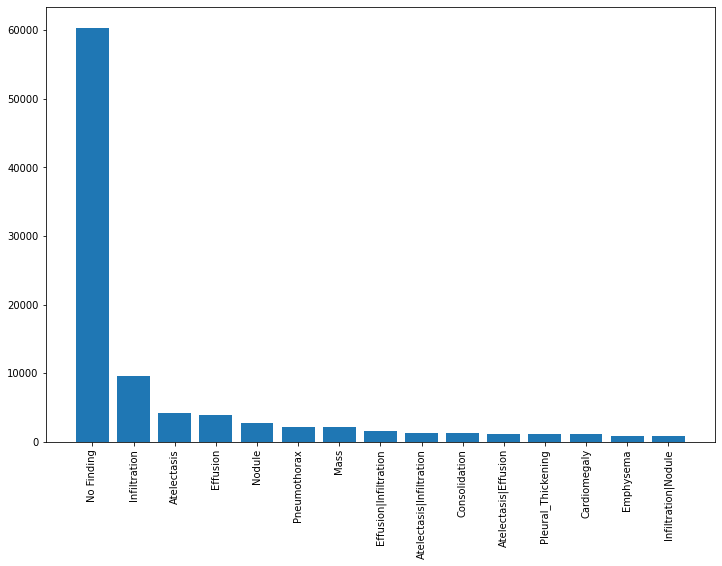

In [7]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1, 1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In public or medical research, the distribution of data is generally analyzed as to **health or disease, female or male, and age**. **When the data is divided, their distribution must be maintained among the divided sub-data in order to avoid bias.** 

The code provided below appears to be performing the following operations:

1. Importing necessary libraries and modules:

   pandas library is imported as pd.
   
   os module is imported.
   
   glob function is imported from the glob module.
   
   numpy library is imported as np.
 
2. Reading a CSV file into a pandas DataFrame:

   The CSV file named 'Data_Entry_2017.csv' is read using pd.read_csv() function.
   
   The resulting DataFrame is assigned to the variable all_xray_df.

3. Creating a dictionary of image paths:

   The glob() function is used to find all file paths matching a specified pattern.
   The file paths are stored in a dictionary, where the key is the base name of the file and the value  is the full path.
   The pattern used in glob() function is '../input/data/images*/ */ *.png'.
   
4. Printing the number of scans found and the total number of headers in the all_xray_df DataFrame.

5. Adding a 'path' column to the DataFrame:

   The 'Image Index' column in all_xray_df is mapped to the corresponding image path from the all_image_paths dictionary using the map() function.
   
   The resulting series is assigned to a new column called 'path' in all_xray_df.

6. Adding a 'No Finding' column to the DataFrame:

   The 'Finding Labels' column in all_xray_df is checked for the presence of the string 'No Finding' using a lambda function.
   If 'No Finding' is found in the labels, the value in the 'No Finding' column is set to True; otherwise, it is set to False.

7. Clipping the 'Patient Age' column:

   The 'Patient Age' column in all_xray_df is clipped between 5 and 100 using np.clip() function.
   
   This ensures that ages below 5 and above 100 are replaced with 5 and 100, respectively.

8. Converting 'Patient Gender' to a binary value:

   The 'Patient Gender' column in all_xray_df is converted to uppercase using the upper() method.
   
   The resulting uppercase values are checked if they are equal to 'M' using a lambda function.
   
   If the value is 'M', it is converted to True (1.0); otherwise, it is converted to False (0.0).
   
   The converted values are stored in a new column called 'Patient Male' in all_xray_df.

9. Printing the number of samples in all_xray_df.

10. Sampling 5 random rows from all_xray_df and displaying the result.

In [8]:
all_xray_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data',  'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['No Finding'] = all_xray_df['Finding Labels'].map(lambda x: 'No Finding' in x)
all_xray_df['Patient Age'] = np.clip(all_xray_df['Patient Age'], 5, 100)
all_xray_df['Patient Male'] = all_xray_df['Patient Gender'].map(lambda x: x.upper() == 'M').astype('float32')
print('The number of samples:', len(all_xray_df))
all_xray_df.sample(5)

Scans found: 112120 , Total Headers 112120
The number of samples: 112120


Image Index        Finding Labels  Follow-up #  Patient ID  \
108236  00029309_000.png  Atelectasis|Fibrosis            0       29309   
110648  00030152_008.png              Effusion            8       30152   
69299   00017106_014.png              Effusion           14       17106   
50425   00012773_000.png                Nodule            0       12773   
60766   00015007_012.png          Infiltration           12       15007   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
108236           51              M            PA                 2021   
110648           16              F            AP                 3056   
69299            58              M            AP                 2500   
50425            41              F            PA                 2516   
60766             5              F            PA                 2046   

        Height]  OriginalImagePixelSpacing[x        y]  Unnamed: 11  \
108236     2021                     0.194308  0.194308          NaN   
110648     2544                     0.139000  0.139000          NaN   
69299      2048                     0.168000  0.168000          NaN   
50425      2828                     0.143000  0.143000          NaN   
60766      1941                     0.143000  0.143000          NaN   

                                                    path  No Finding  \
108236  ../input/data/images_012/images/00029309_000.png       False   
110648  ../input/data/images_012/images/00030152_008.png       False   
69299   ../input/data/images_008/images/00017106_014.png       False   
50425   ../input/data/images_006/images/00012773_000.png       False   
60766   ../input/data/images_007/images/00015007_012.png       False   

        Patient Male  
108236           1.0  
110648           0.0  
69299            1.0  
50425            0.0  
60766            0.0

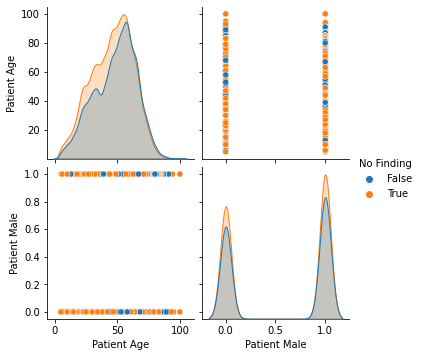

In [9]:
sns.pairplot(all_xray_df[['Patient Age', 'Patient Male', 'No Finding']], hue = 'No Finding')

# Upload CSV File for Object Detection

In [10]:
bbox_list_df = pd.read_csv('/kaggle/input/data/BBox_List_2017.csv')
bbox_list_df.head(5)

Image Index Finding Label     Bbox [x           y           w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   

           h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0   79.186441         NaN         NaN         NaN  
1  313.491525         NaN         NaN         NaN  
2  216.949153         NaN         NaN         NaN  
3   55.322034         NaN         NaN         NaN  
4   78.101695         NaN         NaN         NaN

In [11]:
len(bbox_list_df)

984

In [12]:
# bbox_list_df['Finding Label'].values

In [13]:
# bbox_list_df['Finding Label'].values.tolist()

In [14]:
set(bbox_list_df['Finding Label'].values.tolist())

{'Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltrate',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax'}

In [15]:
len(set(bbox_list_df['Finding Label'].values.tolist()))

8

**The number of data is much smaller than that for classification tasks, because labelling medical data for object detection is more difficult than for classification.** It is extremely difficult to find radiologists who can find their time for such labelling. **Maybe the number of image data is not sufficient to train an AI model to acquire a satisfactory performance level.**

In [16]:
bbox_list_df['Finding Label'].value_counts()

Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: Finding Label, dtype: int64

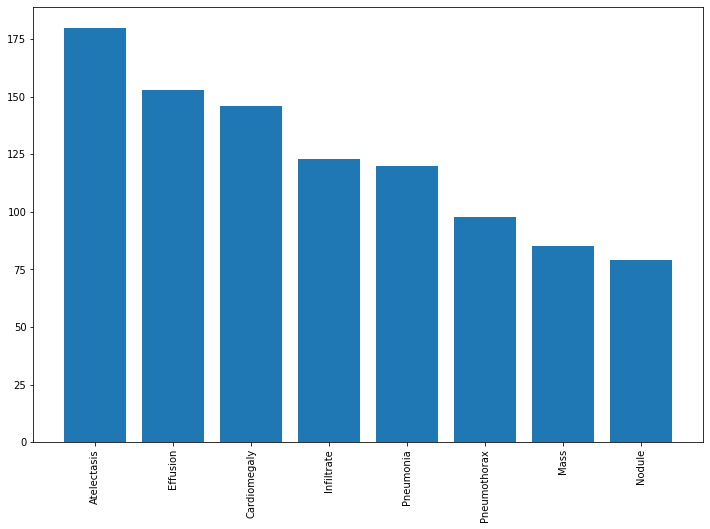

In [17]:
label_counts = bbox_list_df['Finding Label'].value_counts()
fig, ax1 = plt.subplots(1, 1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

# Create a CSV File for Object Detection

In [18]:
A = all_xray_df.set_index('Image Index')
A

Finding Labels  Follow-up #  Patient ID  \
Image Index                                                         
00000001_000.png            Cardiomegaly            0           1   
00000001_001.png  Cardiomegaly|Emphysema            1           1   
00000001_002.png   Cardiomegaly|Effusion            2           1   
00000002_000.png              No Finding            0           2   
00000003_000.png                  Hernia            0           3   
...                                  ...          ...         ...   
00030801_001.png          Mass|Pneumonia            1       30801   
00030802_000.png              No Finding            0       30802   
00030803_000.png              No Finding            0       30803   
00030804_000.png              No Finding            0       30804   
00030805_000.png              No Finding            0       30805   

                  Patient Age Patient Gender View Position  \
Image Index                                                  
00000001_000.png           58              M            PA   
00000001_001.png           58              M            PA   
00000001_002.png           58              M            PA   
00000002_000.png           81              M            PA   
00000003_000.png           81              F            PA   
...                       ...            ...           ...   
00030801_001.png           39              M            PA   
00030802_000.png           29              M            PA   
00030803_000.png           42              F            PA   
00030804_000.png           30              F            PA   
00030805_000.png           27              M            PA   

                  OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  \
Image Index                                                                   
00000001_000.png                 2682     2749                        0.143   
00000001_001.png                 2894     2729                        0.143   
00000001_002.png                 2500     2048                        0.168   
00000002_000.png                 2500     2048                        0.171   
00000003_000.png                 2582     2991                        0.143   
...                               ...      ...                          ...   
00030801_001.png                 2048     2500                        0.168   
00030802_000.png                 2048     2500                        0.168   
00030803_000.png                 2048     2500                        0.168   
00030804_000.png                 2048     2500                        0.168   
00030805_000.png                 2048     2500                        0.171   

                     y]  Unnamed: 11  \
Image Index                            
00000001_000.png  0.143          NaN   
00000001_001.png  0.143          NaN   
00000001_002.png  0.168          NaN   
00000002_000.png  0.171          NaN   
00000003_000.png  0.143          NaN   
...                 ...          ...   
00030801_001.png  0.168          NaN   
00030802_000.png  0.168          NaN   
00030803_000.png  0.168          NaN   
00030804_000.png  0.168          NaN   
00030805_000.png  0.171          NaN   

                                                              path  \
Image Index                                                          
00000001_000.png  ../input/data/images_001/images/00000001_000.png   
00000001_001.png  ../input/data/images_001/images/00000001_001.png   
00000001_002.png  ../input/data/images_001/images/00000001_002.png   
00000002_000.png  ../input/data/images_001/images/00000002_000.png   
00000003_000.png  ../input/data/images_001/images/00000003_000.png   
...                                                            ...   
00030801_001.png  ../input/data/images_012/images/00030801_001.png   
00030802_000.png  ../input/data/images_012/images/00030802_000.png   
00030803_000.png  ../input/data/images_012/images/00030803_000.png   
00

In [19]:
B = bbox_list_df.set_index('Image Index')
B

Finding Label     Bbox [x           y           w  \
Image Index                                                          
00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   
...                        ...         ...         ...         ...   
00029464_015.png   Atelectasis  198.940451  352.900747  615.537778   
00025769_001.png   Atelectasis  701.838229  572.491858  103.537778   
00016837_002.png   Atelectasis  140.913785  658.962969  271.928889   
00020124_003.png   Atelectasis  175.047118  580.456302  244.622222   
00026920_000.png   Atelectasis  343.438229  446.198524  120.604444   

                          h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
Image Index                                                       
00013118_008.png   79.186441         NaN         NaN         NaN  
00014716_007.png  313.491525         NaN         NaN         NaN  
00029817_009.png  216.949153         NaN         NaN         NaN  
00014687_001.png   55.322034         NaN         NaN         NaN  
00017877_001.png   78.101695         NaN         NaN         NaN  
...                      ...         ...         ...         ...  
00029464_015.png  323.128889         NaN         NaN         NaN  
00025769_001.png   63.715556         NaN         NaN         NaN  
00016837_002.png   94.435556         NaN         NaN         NaN  
00020124_003.png  103.537778         NaN         NaN         NaN  
00026920_000.png   53.475556         NaN         NaN         NaN  

[984 rows x 8 columns]

In [20]:
list_df = B.join(A, how = "inner")
list_df.head(5)

Finding Label     Bbox [x           y           w  \
Image Index                                                          
00000032_037.png    Infiltrate  339.166138  119.195767  172.292063   
00000072_000.png   Atelectasis  356.503704  567.805291  127.864550   
00000147_001.png   Atelectasis  617.650794  599.229630  100.774603   
00000149_006.png   Atelectasis  603.661017  460.239556  249.491525   
00000150_002.png     Pneumonia  601.396825  595.978836  215.635979   

                          h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  \
Image Index                                                        
00000032_037.png  351.085714         NaN         NaN         NaN   
00000072_000.png   82.353439         NaN         NaN         NaN   
00000147_001.png  179.877249         NaN         NaN         NaN   
00000149_006.png   90.033898         NaN         NaN         NaN   
00000150_002.png  180.960847         NaN         NaN         NaN   

                                      Finding Labels  Follow-up #  ...  \
Image Index                                                        ...   
00000032_037.png     Cardiomegaly|Edema|Infiltration           37  ...   
00000072_000.png                         Atelectasis            0  ...   
00000147_001.png                         Atelectasis            1  ...   
00000149_006.png                         Atelectasis            6  ...   
00000150_002.png  Atelectasis|Infiltration|Pneumonia            2  ...   

                  Patient Gender  View Position OriginalImage[Width Height]  \
Image Index                                                                   
00000032_037.png               F             AP                2500    2048   
00000072_000.png               F             PA                2450    2839   
00000147_001.png               F             PA                2742    2948   
00000149_006.png               M             AP                2500    2048   
00000150_002.png               F             AP                3056    2544   

                  OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
Image Index                                                         
00000032_037.png                        0.168  0.168          NaN   
00000072_000.png                        0.143  0.143          NaN   
00000147_001.png                        0.143  0.143          NaN   
00000149_006.png                        0.168  0.168          NaN   
00000150_002.png                        0.139  0.139          NaN   

                                                              path  \
Image Index                                                          
00000032_037.png  ../input/data/images_001/images/00000032_037.png   
00000072_000.png  ../input/data/images_001/images/00000072_000.png   
00000147_001.png  ../input/data/images_001/images/00000147_001.png   
00000149_006.png  ../input/data/images_001/images/00000149_006.png   
00000150_002.png  ../input/data/images_001/images/00000150_002.png   

                  No Finding Patient Male  
Image Index                                
00000032_037.png       False          0.0  
00000072_000.png       False          0.0  
00000147_001.png       False          0.0  
00000149_006.png       False          1.0  
00000150_002.png       False          0.0  

[5 rows x 22 columns]

In [21]:
list_df = list_df.reset_index(drop = False)
list_df.head(5)

Image Index Finding Label     Bbox [x           y           w  \
0  00000032_037.png    Infiltrate  339.166138  119.195767  172.292063   
1  00000072_000.png   Atelectasis  356.503704  567.805291  127.864550   
2  00000147_001.png   Atelectasis  617.650794  599.229630  100.774603   
3  00000149_006.png   Atelectasis  603.661017  460.239556  249.491525   
4  00000150_002.png     Pneumonia  601.396825  595.978836  215.635979   

           h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  \
0  351.085714         NaN         NaN         NaN   
1   82.353439         NaN         NaN         NaN   
2  179.877249         NaN         NaN         NaN   
3   90.033898         NaN         NaN         NaN   
4  180.960847         NaN         NaN         NaN   

                       Finding Labels  ...  Patient Gender  View Position  \
0     Cardiomegaly|Edema|Infiltration  ...               F             AP   
1                         Atelectasis  ...               F             PA   
2                         Atelectasis  ...               F             PA   
3                         Atelectasis  ...               M             AP   
4  Atelectasis|Infiltration|Pneumonia  ...               F             AP   

   OriginalImage[Width Height] OriginalImagePixelSpacing[x     y]  \
0                 2500    2048                       0.168  0.168   
1                 2450    2839                       0.143  0.143   
2                 2742    2948                       0.143  0.143   
3                 2500    2048                       0.168  0.168   
4                 3056    2544                       0.139  0.139   

   Unnamed: 11                                              path  No Finding  \
0          NaN  ../input/data/images_001/images/00000032_037.png       False   
1          NaN  ../input/data/images_001/images/00000072_000.png       False   
2          NaN  ../input/data/images_001/images/00000147_001.png       False   
3          NaN  ../input/data/images_001/images/00000149_006.png       False   
4          NaN  ../input/data/images_001/images/00000150_002.png       False   

   Patient Male  
0           0.0  
1           0.0  
2           0.0  
3           1.0  
4           0.0  

[5 rows x 23 columns]

In [22]:
list_df = list_df.drop(['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 11'], axis = 1)
list_df.head(5)

Image Index Finding Label     Bbox [x           y           w  \
0  00000032_037.png    Infiltrate  339.166138  119.195767  172.292063   
1  00000072_000.png   Atelectasis  356.503704  567.805291  127.864550   
2  00000147_001.png   Atelectasis  617.650794  599.229630  100.774603   
3  00000149_006.png   Atelectasis  603.661017  460.239556  249.491525   
4  00000150_002.png     Pneumonia  601.396825  595.978836  215.635979   

           h]                      Finding Labels  Follow-up #  Patient ID  \
0  351.085714     Cardiomegaly|Edema|Infiltration           37          32   
1   82.353439                         Atelectasis            0          72   
2  179.877249                         Atelectasis            1         147   
3   90.033898                         Atelectasis            6         149   
4  180.960847  Atelectasis|Infiltration|Pneumonia            2         150   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           55              F            AP                 2500     2048   
1           67              F            PA                 2450     2839   
2           66              F            PA                 2742     2948   
3           71              M            AP                 2500     2048   
4           55              F            AP                 3056     2544   

   OriginalImagePixelSpacing[x     y]  \
0                        0.168  0.168   
1                        0.143  0.143   
2                        0.143  0.143   
3                        0.168  0.168   
4                        0.139  0.139   

                                               path  No Finding  Patient Male  
0  ../input/data/images_001/images/00000032_037.png       False           0.0  
1  ../input/data/images_001/images/00000072_000.png       False           0.0  
2  ../input/data/images_001/images/00000147_001.png       False           0.0  
3  ../input/data/images_001/images/00000149_006.png       False           1.0  
4  ../input/data/images_001/images/00000150_002.png       False           0.0

In [23]:
list_df.to_csv('BBox List.csv', header = True, index = False)

# Visualize Sample Data

In [24]:
list_df.loc[0, :]

Image Index                                                    00000032_037.png
Finding Label                                                        Infiltrate
Bbox [x                                                              339.166138
y                                                                    119.195767
w                                                                    172.292063
h]                                                                   351.085714
Finding Labels                                  Cardiomegaly|Edema|Infiltration
Follow-up #                                                                  37
Patient ID                                                                   32
Patient Age                                                                  55
Patient Gender                                                                F
View Position                                                                AP
OriginalImage[Width                     

In [25]:
list_df.iloc[0, 2:6]

Bbox [x    339.166138
y          119.195767
w          172.292063
h]         351.085714
Name: 0, dtype: object

In [26]:
list_df.iloc[0, 2:6][0].dtype

dtype('float64')

In [27]:
list_df.loc[0, 'Bbox [x':'h]']

Bbox [x    339.166138
y          119.195767
w          172.292063
h]         351.085714
Name: 0, dtype: object

In [28]:
list_df.iloc[0, 2:6][0] + list_df.iloc[0, 2:6][2]

511.458201058202

In [29]:
list_df.iloc[0, 2:6][1] + list_df.iloc[0, 2:6][3]

470.281481481481

In [30]:
list_df.iloc[0, 12:14]

OriginalImage[Width    2500
Height]                2048
Name: 0, dtype: object

In [31]:
list_df.loc[0, 'OriginalImage[Width':'Height]']

OriginalImage[Width    2500
Height]                2048
Name: 0, dtype: object

In [32]:
list_df.iloc[0, 12:14][0]

2500

In [33]:
list_df.iloc[0, 12:14][0].dtype

dtype('int64')

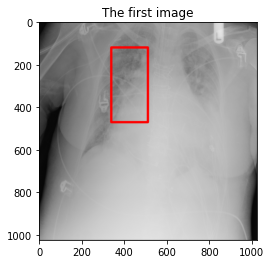

In [34]:
import cv2
image0 = cv2.imread('../input/data/images_001/images/00000032_037.png')
cv2.rectangle(image0, (int(list_df.iloc[0, 2:6][0]), int(list_df.iloc[0, 2:6][1])), (int(list_df.iloc[0, 2:6][0] + list_df.iloc[0, 2:6][2]), int(list_df.iloc[0, 2:6][1] + list_df.iloc[0, 2:6][3])), (255, 0, 0), 10)
plt.title('The first image')
plt.imshow(image0)

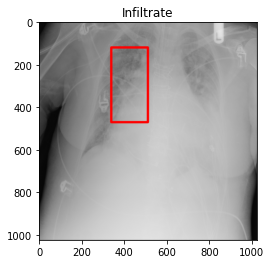

In [35]:
import cv2
image0 = cv2.imread(list_df.loc[0, 'path'])
cv2.rectangle(image0, (int(list_df.iloc[0, 2:6][0]), int(list_df.iloc[0, 2:6][1])), (int(list_df.iloc[0, 2:6][0] + list_df.iloc[0, 2:6][2]), int(list_df.iloc[0, 2:6][1] + list_df.iloc[0, 2:6][3])), (255, 0, 0), 10)
plt.title(list_df.loc[0, 'Finding Label'])
plt.imshow(image0)

**Mass and nodule are generally small and similar to each other and often used interchangeably.** Pneumothorax (air) appears in the upper part of the lung. Cardiomegaly is the only disease of the heart among the diseases. Atelectasis (no air) can appear anywhere in the lung.

Object Detections in Chest X-Ray


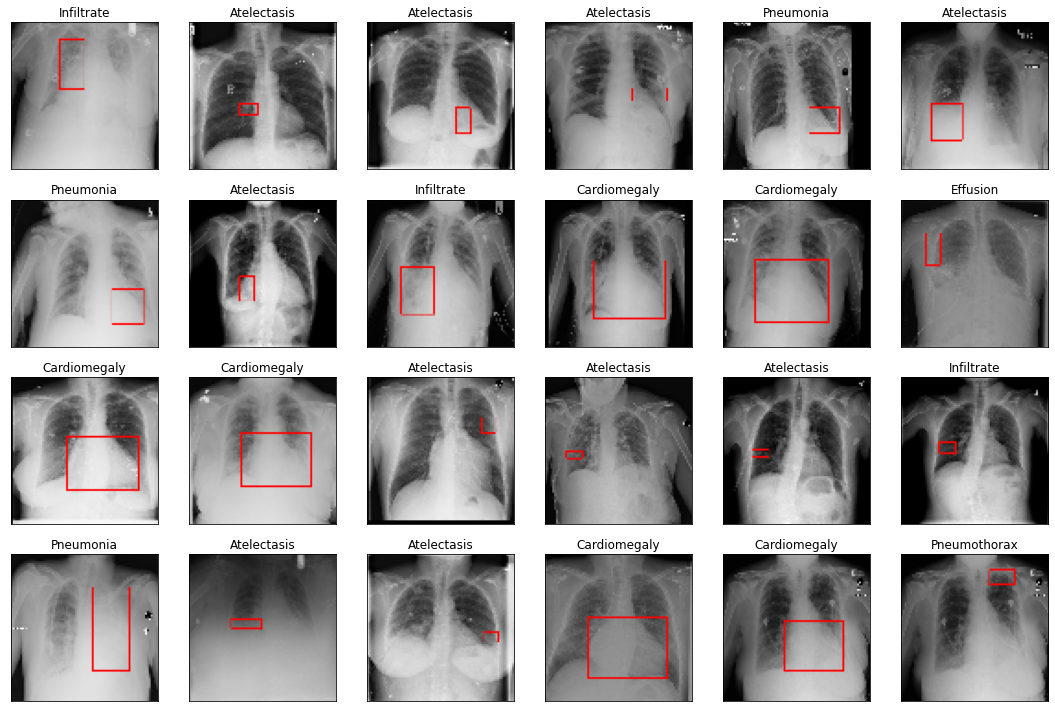

In [36]:
print("Object Detections in Chest X-Ray")
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(list_df.loc[i, 'path'])
    cv2.rectangle(img, (int(list_df.iloc[i, 2:6][0]), int(list_df.iloc[i, 2:6][1])), (int(list_df.iloc[i, 2:6][0] + list_df.iloc[i, 2:6][2]), int(list_df.iloc[i, 2:6][1] + list_df.iloc[i, 2:6][3])), (255, 0, 0), 10)
    img = cv2.resize(img, (80, 80))
    ax.imshow(img)
    ax.set_title(list_df.loc[i, 'Finding Label'])
fig.tight_layout()    

plt.show()

# Create Dataset Composed of Image, Bounding Box, and Label

In [37]:
import torch
torch.__version__

'1.11.0'

In [38]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [39]:
import torchvision
torchvision.__version__

'0.12.0'

In [40]:
from PIL import Image
from torchvision import transforms

In [41]:
images = []
for i in range(len(list_df)):
    image_path = list_df.loc[i, 'path']
    image = Image.open(image_path)
    image = transforms.Compose([transforms.ToTensor() ])(image)
    images.append(image)

In [42]:
images[0:3]

[tensor([[[0.0157, 0.0275, 0.0275,  ..., 0.0863, 0.0941, 0.0549],
          [0.0353, 0.0549, 0.0588,  ..., 0.1765, 0.1882, 0.1137],
          [0.0353, 0.0549, 0.0549,  ..., 0.1725, 0.1804, 0.1059],
          ...,
          [0.3412, 0.6000, 0.5804,  ..., 0.0510, 0.0588, 0.0353],
          [0.3490, 0.6157, 0.5961,  ..., 0.0510, 0.0588, 0.0353],
          [0.1686, 0.2980, 0.2863,  ..., 0.0235, 0.0275, 0.0196]]]),
 tensor([[[0.8627, 0.8549, 0.8627,  ..., 0.6863, 0.8157, 0.4902],
          [0.8627, 0.8627, 0.8471,  ..., 0.6353, 0.7529, 0.4510],
          [0.8549, 0.8706, 0.8431,  ..., 0.6157, 0.7216, 0.4431],
          ...,
          [0.8118, 0.7882, 0.7882,  ..., 0.4392, 0.5490, 0.3294],
          [0.7922, 0.7922, 0.8078,  ..., 0.4510, 0.5529, 0.3373],
          [0.7961, 0.8039, 0.8118,  ..., 0.4510, 0.5373, 0.3294]]]),
 tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.9412, 0.9451, 0.9569],
          [0.0000, 0.0000, 0.0000,  ..., 0.9294, 0.9451, 0.9529],
          [0.0000, 0.0000, 0.0000,  ...,

In [43]:
images[0].shape

torch.Size([1, 1024, 1024])

**There are 5 images having abnormal size that must be removed from the dataset.**

In [44]:
# abnormal images
abnormal = []

for i in range(len(list_df)):
    if images[i].shape != torch.Size([1, 1024, 1024]):
        abnormal.append(i)
        
abnormal

[39, 66, 81, 259, 406]

In [45]:
images[39].shape

torch.Size([4, 1024, 1024])

In [46]:
len(images)

984

In [47]:
# images
images = []
for i in range(len(list_df)):
    if (i != 39) & (i != 66) & (i != 81) & (i != 259) & (i != 406):
        image_path = list_df.loc[i, 'path']
        image = Image.open(image_path)
        image = transforms.Compose([transforms.ToTensor() ])(image)
        images.append(image)

In [48]:
abnormal = []

for i in range(len(images)):
    if images[i].shape != torch.Size([1, 1024, 1024]):
        abnormal.append(i)
        
abnormal

[]

In [49]:
# boxes
boxes = []
for i in range(len(list_df)):
    if (i != 39) & (i != 66) & (i != 81) & (i != 259) & (i != 406):        
        box = [list_df.iloc[i, 2:6][0], list_df.iloc[i, 2:6][1], list_df.iloc[i, 2:6][0] + list_df.iloc[i, 2:6][2], list_df.iloc[i, 2:6][1] + list_df.iloc[i, 2:6][3]]
        boxes.append([box]) 
                                                                           
boxes = torch.tensor(boxes, dtype = torch.float32) 

In [50]:
boxes

tensor([[[339.1661, 119.1958, 511.4582, 470.2815]],

        [[356.5037, 567.8053, 484.3683, 650.1588]],

        [[617.6508, 599.2296, 718.4254, 779.1069]],

        ...,

        [[612.6934, 459.9846, 836.8356, 593.1046]],

        [[611.9538, 440.5096, 770.1049, 591.8341]],

        [[632.9492, 251.9684, 860.7458, 462.4091]]])

In [51]:
# labels
bbox_labels = [
 'Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltrate',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax']

labels = []
for i in range(len(list_df)):
    if (i != 39) & (i != 66) & (i != 81) & (i != 259) & (i != 406):        
        label = list_df.loc[i, 'Finding Label']
        label = bbox_labels.index(label)
        labels.append([label])
    
labels = torch.tensor(labels, dtype = torch.int64)

In [52]:
labels[0:5]

tensor([[3],
        [0],
        [0],
        [0],
        [6]])

In [53]:
# dataset
dataset = []
for i in range(len(images)):
    data = (images[i], {'boxes': boxes[i], 'labels': labels[i]})
    dataset.append(data)

In [54]:
dataset[0:5]

[(tensor([[[0.0157, 0.0275, 0.0275,  ..., 0.0863, 0.0941, 0.0549],
           [0.0353, 0.0549, 0.0588,  ..., 0.1765, 0.1882, 0.1137],
           [0.0353, 0.0549, 0.0549,  ..., 0.1725, 0.1804, 0.1059],
           ...,
           [0.3412, 0.6000, 0.5804,  ..., 0.0510, 0.0588, 0.0353],
           [0.3490, 0.6157, 0.5961,  ..., 0.0510, 0.0588, 0.0353],
           [0.1686, 0.2980, 0.2863,  ..., 0.0235, 0.0275, 0.0196]]]),
  {'boxes': tensor([[339.1661, 119.1958, 511.4582, 470.2815]]),
   'labels': tensor([3])}),
 (tensor([[[0.8627, 0.8549, 0.8627,  ..., 0.6863, 0.8157, 0.4902],
           [0.8627, 0.8627, 0.8471,  ..., 0.6353, 0.7529, 0.4510],
           [0.8549, 0.8706, 0.8431,  ..., 0.6157, 0.7216, 0.4431],
           ...,
           [0.8118, 0.7882, 0.7882,  ..., 0.4392, 0.5490, 0.3294],
           [0.7922, 0.7922, 0.8078,  ..., 0.4510, 0.5529, 0.3373],
           [0.7961, 0.8039, 0.8118,  ..., 0.4510, 0.5373, 0.3294]]]),
  {'boxes': tensor([[356.5037, 567.8053, 484.3683, 650.1588]]),
  

In [55]:
len(dataset)

979

# Split the Dataset into Training, Validation, and Test Datasets

The code provided below is using torch.utils.data.random_split() function to split a dataset into three subsets: train, validation, and test. The dataset being split is referred to as dataset, and the split lengths are specified as [900, 55, 24]. The random splitting is done using a generator with a manual seed of 42.

The resulting subsets are assigned to train, val, and test variables. Each subset will be a Subset object from torch.utils.data module.

Make sure you have the necessary imports for the required modules (torch and torch.utils.data).

In [56]:
train, val, test = torch.utils.data.random_split(dataset = dataset, lengths = [900, 55, 24], generator = torch.Generator().manual_seed(42))

In [57]:
len(train), len(val), len(test)

(900, 55, 24)

The code provided below is creating data loaders for the train, validation, and test subsets of the dataset. These data loaders can be used for training, validation, and testing of a neural network model.

In [58]:
train_loader = torch.utils.data.DataLoader(train, batch_size = 10, shuffle = False, drop_last = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 1)
test_loader = torch.utils.data.DataLoader(test, batch_size = 24)

The code provided below is creating a mapping between class names and their corresponding indices. Here's a breakdown of the code:

1. Importing necessary modules and functions:

   The draw_bounding_boxes function is imported from torchvision.utils.
   
   The FastRCNNPredictor class is imported from torchvision.models.detection.faster_rcnn.

2. Defining the index2name list:

   The index2name list contains the names of different classes, such as 'Atelectasis', 'Cardiomegaly', 'Effusion', and so on.

3. Printing the index2name list:

   The print() function is used to display the index2name list.

4. Creating the name2index dictionary:
   
   An empty dictionary named name2index is created.
   
   A loop is used to iterate over the indices of the index2name list.
   
   In each iteration, the class name at the current index is used as the key, and the index is used as the value in the name2index dictionary.
   
   After the loop finishes, the name2index dictionary will contain mappings from class names to their corresponding indices.

5. Printing the name2index dictionary:

   The print() function is used to display the name2index dictionary, which shows the mapping of class names to indices.

By having the mappings between class names and indices, you can easily convert between the two representations when working with classification or object detection tasks.

In [59]:
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

index2name = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']
    
print(index2name)

name2index = {}
for i in range(len(index2name)):
    name2index[index2name[i]] = i
print(name2index)

['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']
{'Atelectasis': 0, 'Cardiomegaly': 1, 'Effusion': 2, 'Infiltrate': 3, 'Mass': 4, 'Nodule': 5, 'Pneumonia': 6, 'Pneumothorax': 7}


The code provided below defines a function show_boxes() to display an image with bounding boxes and labels. Here's a breakdown of the code:

1. Defining the show_boxes() function:

    The function takes three arguments: image, boxes, and names.
    
    image is the input image.
    
    boxes is a tensor containing the coordinates of the bounding boxes.
    
    names is a list of class names corresponding to the bounding boxes.

2. Drawing the bounding boxes on the image:

    The draw_bounding_boxes() function from torchvision.utils is used to draw the bounding boxes on the image.
    
    The labels parameter is set to names to display the class labels on the bounding boxes.
    
    The resulting image with drawn bounding boxes is assigned to drawn_boxes.

3. Displaying the image:

    The plt.figure() function is used to create a figure with a specified size.
    
    The plt.imshow() function is used to display the image.
    
    The np.transpose() function is used to change the dimension order of the image from (C, H, W) to (H, W, C) to match the expected format for visualization.
    
    The plt.tick_params() function is used to remove tick labels and tick marks.
    
    The plt.show() function is called to display the figure.

4. Extracting an image and target from the training data loader:

    The iter() function is used to create an iterator from the train_loader.
    
    The next() function is used to get the next batch of data from the iterator, returning image and target.

5. Printing the target:

    The print() function is used to display the target, which contains the ground truth information for the current batch.

6. Printing the image:

    The print() function is used to display the image, which contains the input image for the current batch.

7. Preparing the image for visualization:

    The image tensor is accessed using index [0] to select the first image from the batch.
    
    The pixel values in image are multiplied by 255 and cast to torch.uint8 to convert them to the expected range for image visualization.

8. Extracting the bounding boxes and labels:

    The boxes tensor is accessed using index [0] to select the bounding boxes for the first image in the batch.
    
    The labels tensor is accessed using index [0] to select the class labels for the first image in the batch.
    
    The class labels are converted to their corresponding class names using the index2name mapping.

9. Calling show_boxes() to display the image with bounding boxes and labels:

    The preprocessed image, bounding boxes, and class names are passed as arguments to the show_boxes() function.

This code segment demonstrates how to visualize an image with ground truth bounding boxes and labels using the show_boxes() function.

{'boxes': tensor([[[134.3661, 132.1989, 476.7831, 602.4804]],

        [[404.1820, 302.3238, 901.5535, 745.5153]],

        [[559.1365, 378.1757, 793.1937, 621.9852]],

        [[368.4233, 340.2497, 862.5439, 736.8466]],

        [[723.8434, 449.6931, 893.9683, 743.3481]],

        [[469.1979, 465.9471, 844.1227, 839.7883]],

        [[609.2800, 189.1935, 683.2355, 260.8735]],

        [[390.0952, 313.1598, 845.2064, 672.9143]],

        [[200.4656, 487.6190, 678.3323, 966.5693]],

        [[ 75.8519, 202.6328, 221.0540, 717.3418]]]), 'labels': tensor([[7],
        [1],
        [3],
        [1],
        [2],
        [6],
        [4],
        [1],
        [1],
        [7]])}
tensor([[[[0.1608, 0.1373, 0.1255,  ..., 0.5882, 0.5882, 0.5961],
          [0.1647, 0.1373, 0.1216,  ..., 0.4980, 0.5098, 0.5176],
          [0.1608, 0.1333, 0.1176,  ..., 0.4157, 0.4275, 0.4588],
          ...,
          [0.2314, 0.2471, 0.2510,  ..., 0.4980, 0.5059, 0.5216],
          [0.2353, 0.2471, 0.2549,  ..

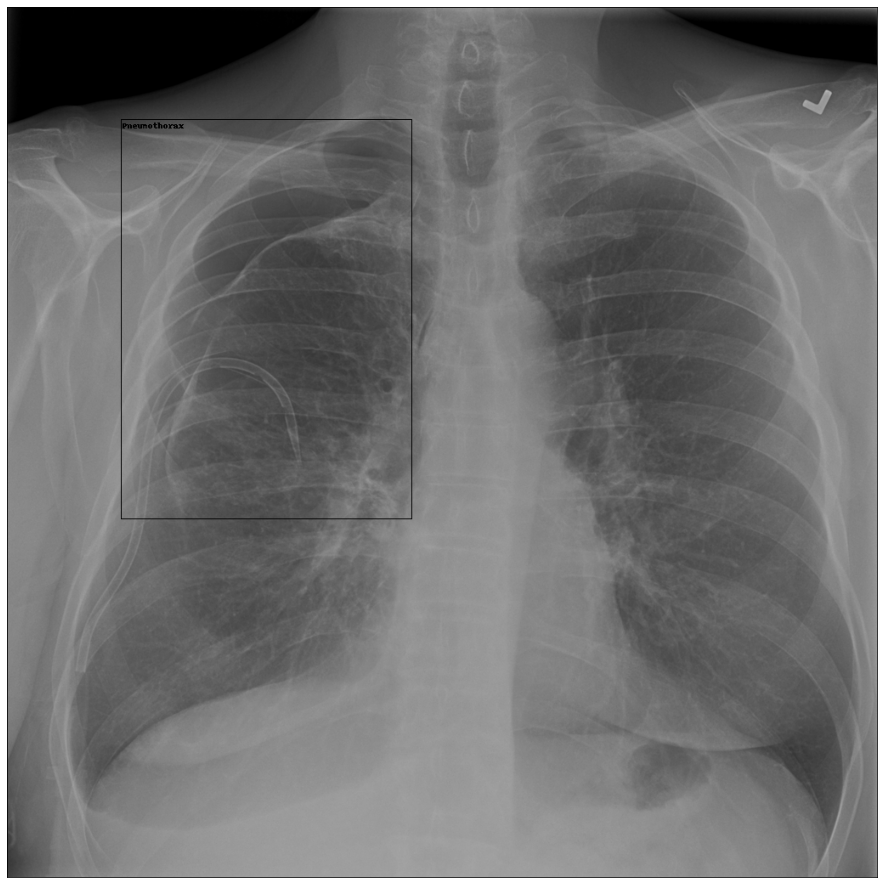

In [60]:
def show_boxes(image, boxes, names):
    drawn_boxes = draw_bounding_boxes(image, boxes, labels = names)

    plt.figure(figsize = (16, 16))
    plt.imshow(np.transpose(drawn_boxes, (1, 2, 0)))
    plt.tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
    plt.show()

dataiter = iter(train_loader)
image, target = next(dataiter)
print(target)

print(image)
image = image[0]
image = (image * 255).to(torch.uint8) 

boxes = target["boxes"][0]

labels = target["labels"][0]
names = [index2name[label.item()] for label in labels]

show_boxes(image, boxes, names)

# Import RetinaNet

The code provided below performs the following tasks:

1. Loading a pre-trained RetinaNet model:

   The retinanet_resnet50_fpn() function from torchvision.models.detection is used to **load a pre-trained RetinaNet model with a ResNet-50 backbone**.
   
   **The pretrained=True argument indicates that the model should be loaded with pre-trained weights.**
   
   The resulting model is assigned to the variable model.

2. Configuring the number of classes and anchors:

   **The number of classes is set to the length of index2name plus 1 (an additional class for background).**

   **The number of anchors is obtained from the model's classification_head.num_anchors.**

3. Modifying the model's classification head:

   The num_classes is updated for the model's classification head to match the number of classes.

   **A new convolutional layer (cls_logits) is created with the specified number of output channels (num_anchors * num_classes).**

   The weights of cls_logits are initialized using a normal distribution with a standard deviation of 0.01, and the bias is set to a constant value.

   The model's classification head is updated with the new cls_logits layer.

4. Freezing model parameters:

   Initially, all parameters in the model are set to not require gradients by setting requires_grad to False.

   Then, the parameters of the classification head and regression head are set to require gradients by setting requires_grad to True.

5. Moving the model to GPU:The model is moved to the GPU using the cuda() method.

This code prepares **the pre-trained RetinaNet model for fine-tuning by modifying the classification head, freezing the backbone parameters, and enabling gradients for the classification and regression heads**. The model is then moved to the GPU for efficient computation.

In [61]:
import math
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained = True)

num_classes = len(index2name) + 1
num_anchors = model.head.classification_head.num_anchors

model.head.classification_head.num_classes = num_classes

cls_logits = torch.nn.Conv2d(256, num_anchors * num_classes, kernel_size = 3, stride = 1, padding = 1)
torch.nn.init.normal_(cls_logits.weight, std = 0.01)
torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))
model.head.classification_head.cls_logits = cls_logits

for p in model.parameters():
    p.requires_grad = False

for p in model.head.classification_head.parameters():
    p.requires_grad = True

for p in model.head.regression_head.parameters():
    p.requires_grad = True

model.cuda()

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [62]:
model.backbone.body.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [63]:
model.backbone.body.conv1.in_channels

3

In [64]:
# The data images are black and white!
model.backbone.body.conv1.in_channels = 1

In [65]:
model.backbone.body.conv1

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [66]:
model.cuda()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


# Training and Validation with RetinaNet

The code provided below is performing the training and validation process for the fine-tuned RetinaNet model. Here's a breakdown of the code:

1. Defining the optimizer:

    The torch.optim.SGD optimizer is used with **the specified learning rate (lr), momentum, and weight decay**.
    
    The parameters that require gradients (i.e., those in params) are passed to the optimizer.

2. Setting up variables and lists for tracking losses and epochs:

    epoch_number, train_losses, and val_losses are lists to store the epoch numbers, training losses, and validation losses, respectively.
    
    model.train() sets the model to training mode.

3. Training loop:

    The loop runs for the specified number of epochs.
    
    train_loss is initialized as 0 for each epoch.
    
    For each batch in the training data loader:
    
        losses is initialized as 0 for each batch.
        
        For each image and target in the batch:
        
            The image and targets are moved to the GPU.
            
            The model is called with the image and target to obtain the loss dictionary.
            
            The individual losses from the dictionary are summed up to calculate the total loss.
            
            The total loss is added to train_loss.
            
            The individual loss is appended to the loss_list.
            
        The total loss is divided by batch_size to obtain the average loss for the batch.
        
        The optimizer parameters are zeroed.
        
        The losses are backpropagated (backward()) and the optimizer is updated (step()).
        
        The loss is printed for every 10th iteration.
        
    The average training loss for the epoch is calculated and appended to train_losses.

4. Validation loop:

    val_loss is initialized as 0 for each epoch.
    
    The model is set to evaluation mode (model.eval()) to disable gradient calculations and batch normalization.
    
    For each image and target in the validation data loader:
    
        The image and target are moved to the GPU.
        
        The model is called with the image and target to obtain the loss dictionary.
        
        The loss from the dictionary is accumulated to calculate the total validation loss.
        
    The average validation loss for the epoch is calculated and appended to val_losses.

5. Saving the model:

    If the current validation loss is lower than the minimum validation loss seen so far (min(val_losses)), the model's state dictionary is saved to a file named 'object_detection.pt'.
    
    If the current validation loss is not lower, the patience counter is incremented.
    
    If patience reaches 2 (indicating no improvement for 2 consecutive epochs), the training loop is terminated.
    
    The model is set back to training mode (model.train()).

This code trains the fine-tuned RetinaNet model using the specified optimizer and data loaders for a specified number of epochs. **It tracks the training and validation losses and saves the model when there is an improvement in the validation loss. The training loop can be terminated early if there is no improvement for a certain number of epochs specified by patience.**

In [67]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)
epoch_number = []
train_losses = []
val_losses = []
model.train()
patience = 0
epochs = 10
batch_size = 10
loss_list = []
# training
for epoch in range(epochs):
    
    train_loss = 0
    for i, (images, targets) in enumerate(train_loader):
        losses = 0
        for j in range(len(images)):

            image = images[j].unsqueeze(0).cuda()

            boxes = targets["boxes"][j].cuda()
            labels = targets["labels"][j].cuda()
            target = [{"boxes":boxes, "labels":labels}]

            loss_dic = model(image, target)
            loss = sum(loss for loss in loss_dic.values())
            losses += loss
            train_loss += loss.item()
            loss_list.append(loss)
            
        losses /= batch_size
        # zero the parameter gradients + backward + optimize
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 9:
            print("epoch:", epoch + 1,  "iteration:", i + 1,  "loss:", loss.item()) 
    train_losses.append(train_loss / ((i + 1) * batch_size))        
    print("train_loss:", train_loss / ((i + 1) * batch_size))

# validation
    val_loss = 0
    with torch.no_grad():
        model.eval()
        for i, (image, target) in enumerate(val_loader):

            image = image.cuda()

            boxes = target["boxes"][0].cuda()
            labels = target["labels"][0].cuda()
            target = [{"boxes":boxes, "labels":labels}]

            loss_dic = model(image, target)
            loss = loss_dic[0]['scores'].sum()
            val_loss += loss.item() / batch_size
    val_losses.append(val_loss / len(val))   
    print("val_loss:", val_loss / len(val))
    epoch_number.append(epoch + 1)
    if min(val_losses) < val_loss / len(val):
        patience += 1
        
    else:
        torch.save(model.state_dict(), 'object_detection.pt')
        print('Detected network improvement, saving current model')
                          
    if patience == 2:
        break
    model.train()

epoch: 1 iteration: 10 loss: 1.204477310180664
epoch: 1 iteration: 20 loss: 1.675597906112671
epoch: 1 iteration: 30 loss: 1.7196102142333984
epoch: 1 iteration: 40 loss: 1.2018259763717651
epoch: 1 iteration: 50 loss: 2.1968846321105957
epoch: 1 iteration: 60 loss: 0.627414345741272
epoch: 1 iteration: 70 loss: 1.0355002880096436
epoch: 1 iteration: 80 loss: 1.246473789215088
epoch: 1 iteration: 90 loss: 1.3900179862976074
train_loss: 1.517372990316815
val_loss: 1.7476567146994855
Detected network improvement, saving current model
epoch: 2 iteration: 10 loss: 0.509066641330719
epoch: 2 iteration: 20 loss: 1.2070720195770264
epoch: 2 iteration: 30 loss: 1.5759665966033936
epoch: 2 iteration: 40 loss: 1.1584686040878296
epoch: 2 iteration: 50 loss: 2.177460193634033
epoch: 2 iteration: 60 loss: 0.5864974856376648
epoch: 2 iteration: 70 loss: 0.9243059158325195
epoch: 2 iteration: 80 loss: 1.0550786256790161
epoch: 2 iteration: 90 loss: 1.2754853963851929
train_loss: 1.3170574306117164
v

In [68]:
# loss_list

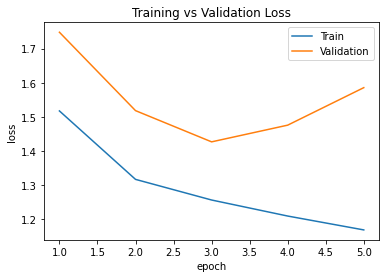

In [69]:
plt.plot(epoch_number, train_losses, label = "Training Loss")
plt.plot(epoch_number, val_losses, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

# Inference with Test Dataset

The code provided is making predictions using the fine-tuned RetinaNet model on the test dataset and visualizing the predicted bounding boxes and labels. Here's a breakdown of the code:

1. Extracting images and targets from the test data loader:

    The iter() function is used to create an iterator from the test_loader.
    
    The next() function is used to get the next batch of data from the iterator, returning images and target.

2. Moving the images to the GPU:

    The images tensor is moved to the GPU using the cuda() method.

3. Setting the model to evaluation mode:

    The model.eval() method is called to set the model to evaluation mode, disabling gradient calculations and batch normalization.

4. Making predictions on the test images:

    Inside the torch.no_grad() context, the model is called with the images tensor to obtain the predictions.
    
    The predictions contain bounding box coordinates and class labels.

5. Printing the predictions:

    The predictions are printed to the console using print(predictions).

6. Preparing the image for visualization:

    The first image from the batch is selected using index [0].
    
    The pixel values in the image are multiplied by 255 and cast to torch.uint8 to convert them to the expected range for image visualization.
    
    The image tensor is moved to the CPU using the cpu() method.

7. Extracting the bounding boxes, labels, and names from the predictions:

    The bounding boxes are extracted from predictions[0]["boxes"] and moved to the CPU using the cpu() method.
    
    The labels are extracted from predictions[0]["labels"], converted to a NumPy array, and clipped to the range of valid class indices.
    
    The class names are retrieved from index2name using the class labels.

8. Printing the predicted class names:

    The predicted class names are printed using print(names).

9. Calling show_boxes() to display the image with predicted bounding boxes and labels:

    The preprocessed image, bounding boxes, and class names are passed as arguments to the show_boxes() function.

This code segment demonstrates how to make predictions using the fine-tuned RetinaNet model on the test dataset and visualize the results using the show_boxes() function.

In [70]:
# importing trained network with better loss of validation
model.load_state_dict(torch.load('object_detection.pt'))

<All keys matched successfully>

[{'boxes': tensor([[ 124.1250,  191.6501,  371.3325,  757.6123],
        [  46.2843,  299.6041,  316.0837,  844.3678],
        [ 696.2188,  213.5927,  872.7539,  607.8321],
        [  80.2772,  179.6812,  251.6748,  652.2082],
        [ 106.4500,  454.6461,  339.6157,  819.6761],
        [ 736.6014,  288.6687,  896.8447,  699.8092],
        [ 775.8397,  234.2353,  929.5720,  635.0278],
        [ 637.3969,  262.9499,  835.6337,  665.0931],
        [  49.6242,  454.3945,  217.7524,  871.3223],
        [ 269.7318,  285.7546,  816.7863,  777.3076],
        [ 762.4803,  107.9411,  940.3182,  837.6116],
        [ 602.5889,  148.4475,  882.1951,  821.8754],
        [ 578.2540,  237.1268,  789.0498,  600.2025],
        [ 628.8506,  149.2149,  848.1634,  515.1108],
        [ 189.7057,  432.4074,  373.6057,  697.4434],
        [ 211.5847,  246.2175,  823.2416,  725.9543],
        [  57.2406,  141.9081,  188.2249,  617.8008],
        [  83.7790,  534.9129,  260.3357,  830.6111],
        [ 626.176

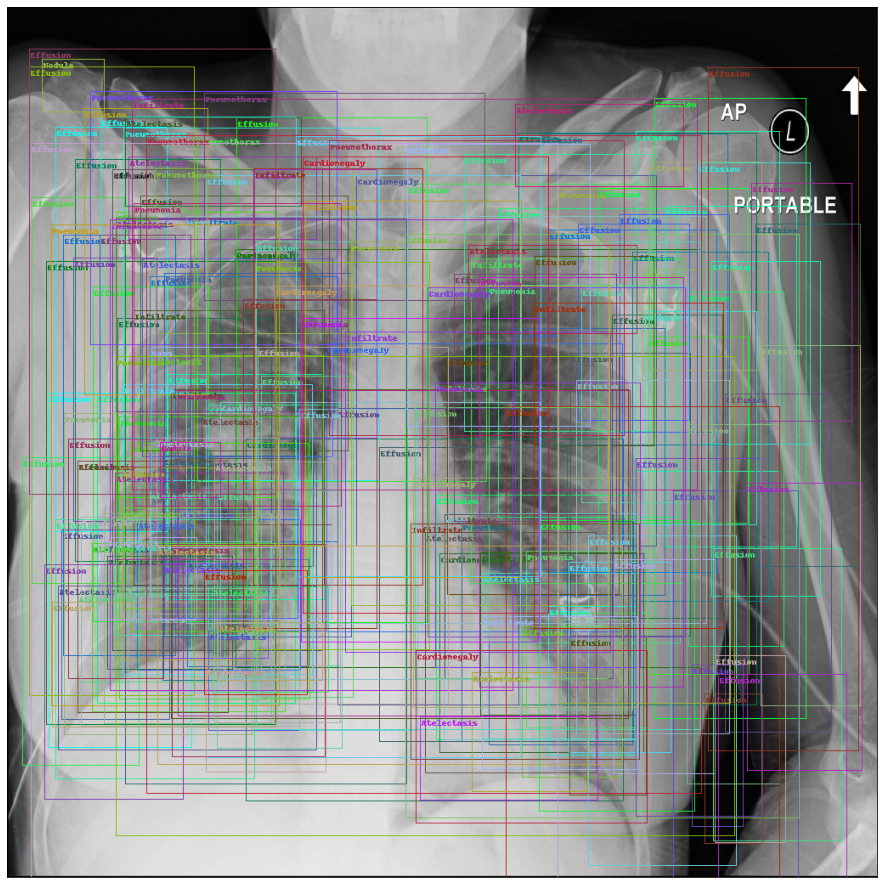

In [71]:
dataiter = iter(test_loader)
images, target = next(dataiter)

images = images.cuda()

model.eval()
with torch.no_grad():
    predictions = model(images)
    print(predictions)

image = (images[0] * 255).to(torch.uint8).cpu()
boxes = predictions[0]["boxes"].cpu()
labels = predictions[0]["labels"].cpu().detach().numpy()
labels = np.where(labels >= len(index2name), 0, labels)
names = [index2name[label.item()] for label in labels]

print(names)
show_boxes(image, boxes, names)

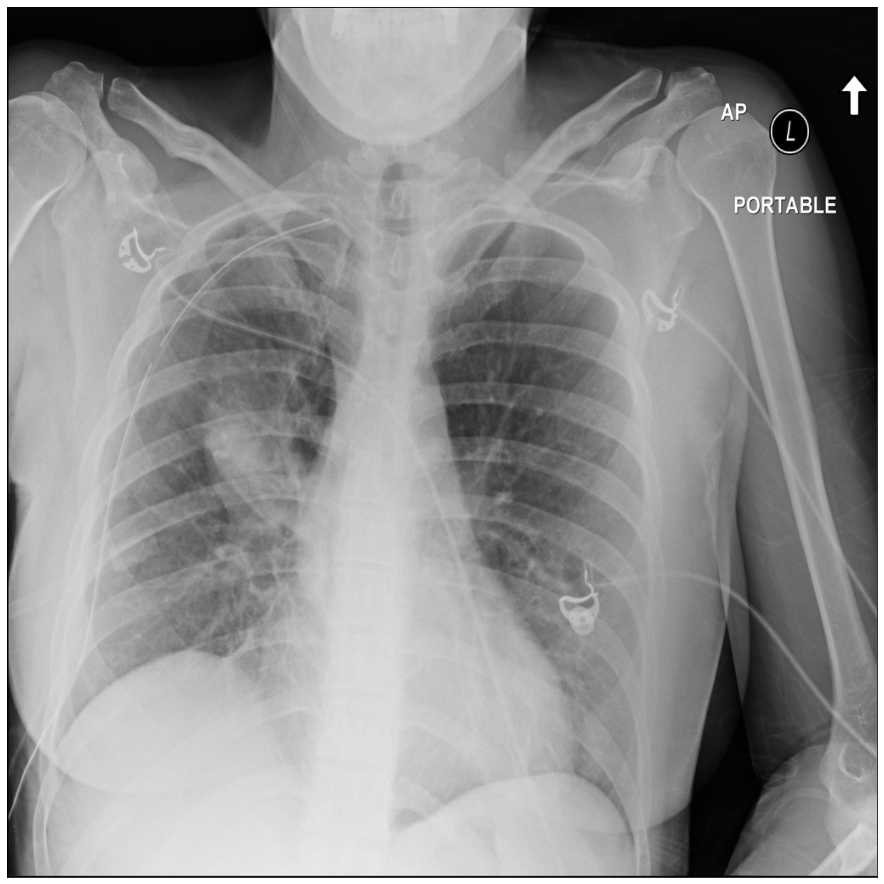

In [72]:
# Choose a box having the score more than 0.5.
boxes = []
names = []
for i, box in enumerate(predictions[0]["boxes"]):
    score = predictions[0]["scores"][i].cpu().detach().numpy()
    if score > 0.5:
        boxes.append(box.cpu().tolist())
        label = predictions[0]["labels"][i].item()
        if label >= len(index2name):
            label = 0
        name = index2name[label]
        names.append(name)
boxes = torch.tensor(boxes)

show_boxes(image, boxes, names)

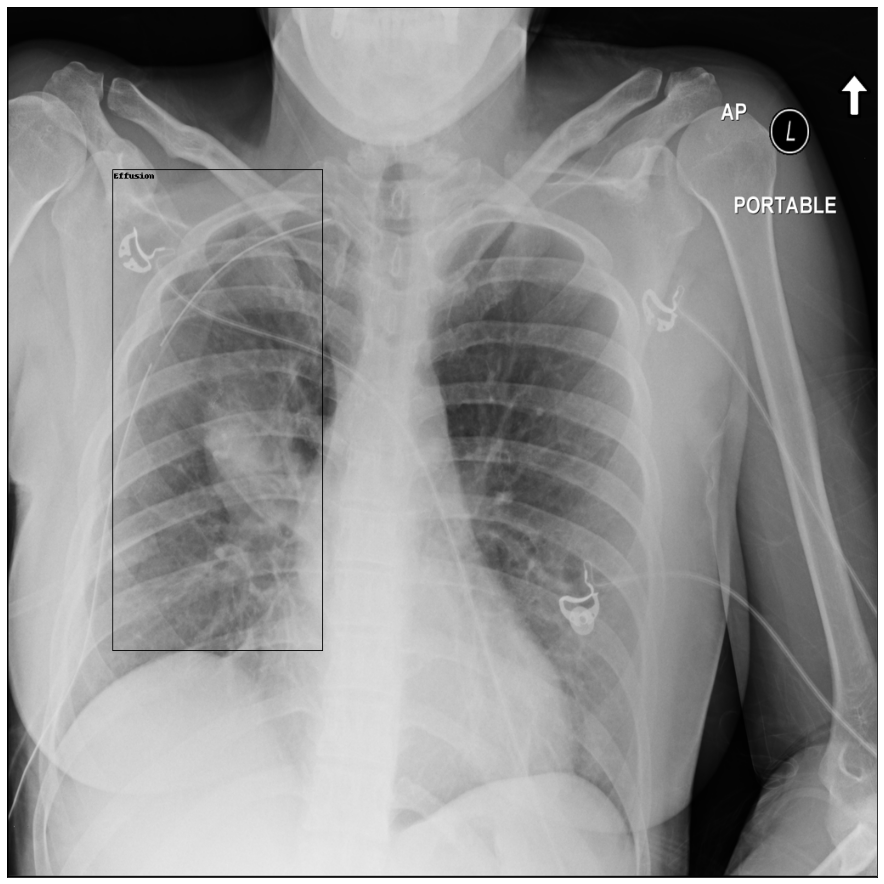

In [73]:
# Choose a boxe having the maximum score.
scores = []
boxes = []
names = []
for i, box in enumerate(predictions[0]["boxes"]):
    score = predictions[0]["scores"][i].cpu().detach().numpy()
    scores.append(score)
    
    if score == max(scores):
        boxes.append(box.cpu().tolist())
        label = predictions[0]["labels"][i].item()
        if label >= len(index2name):
            label = 0
        name = index2name[label]
        names.append(name)
boxes = torch.tensor(boxes)

show_boxes(image, boxes, names)

In [74]:
images

tensor([[[[0.0000, 0.0039, 0.0157,  ..., 0.0157, 0.0157, 0.0157],
          [0.0000, 0.0078, 0.0235,  ..., 0.0275, 0.0275, 0.0275],
          [0.0000, 0.0078, 0.0235,  ..., 0.0275, 0.0275, 0.0275],
          ...,
          [0.0000, 0.0275, 0.0902,  ..., 0.7137, 0.7020, 0.7294],
          [0.0000, 0.0392, 0.1294,  ..., 0.5529, 0.5608, 0.5804],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0157, 0.0275, 0.0275,  ..., 0.0863, 0.0941, 0.0549],
          [0.0353, 0.0549, 0.0588,  ..., 0.1765, 0.1882, 0.1137],
          [0.0353, 0.0549, 0.0549,  ..., 0.1725, 0.1804, 0.1059],
          ...,
          [0.3412, 0.6000, 0.5804,  ..., 0.0510, 0.0588, 0.0353],
          [0.3490, 0.6157, 0.5961,  ..., 0.0510, 0.0588, 0.0353],
          [0.1686, 0.2980, 0.2863,  ..., 0.0235, 0.0275, 0.0196]]],


        [[[0.0078, 0.0157, 0.0118,  ..., 0.0078, 0.0078, 0.0039],
          [0.0157, 0.0314, 0.0314,  ..., 0.0157, 0.0157, 0.0078],
          [0.0157, 0.0314, 0.0275,  ..

In [75]:
target

{'boxes': tensor([[[209.1344, 439.9407, 355.4201, 634.9883]],
 
         [[339.1661, 119.1958, 511.4582, 470.2815]],
 
         [[480.0339, 425.8540, 700.0042, 795.3608]],
 
         [[412.8508, 468.1143, 961.1513, 969.8201]],
 
         [[749.2267, 615.8602, 847.0756, 722.8113]],
 
         [[711.9238, 537.4645, 804.0296, 618.7344]],
 
         [[206.9672, 237.3079, 413.9344, 439.9407]],
 
         [[203.0933, 209.6735, 447.7155, 743.2913]],
 
         [[773.1200, 565.7979, 958.5778, 634.0646]],
 
         [[792.1100, 417.1852, 847.3735, 470.2815]],
 
         [[644.7407, 308.8254, 830.0359, 663.1619]],
 
         [[767.1873, 577.5577, 857.1259, 753.1005]],
 
         [[ 53.0963, 488.7026, 237.3079, 797.5280]],
 
         [[781.2740, 784.5248, 905.8878, 965.4857]],
 
         [[769.3545, 581.8921, 934.0614, 778.0233]],
 
         [[279.3244, 317.7624, 963.1289, 695.5046]],
 
         [[187.1644,  66.3135, 390.8267, 680.7135]],
 
         [[115.9450, 612.2328, 338.0826, 706.5058]],
 
 

In [76]:
"""
for i in range (24):
    print(f"Image{i}")
    image = (images[i] * 255).to(torch.uint8).cpu()
    boxes = predictions[i]["boxes"].cpu()
    labels = predictions[i]["labels"].cpu().detach().numpy()
    labels = np.where(labels >= len(index2name), 0, labels)
    names = [index2name[label.item()] for label in labels]

    print(names)
    show_boxes(image, boxes, names)
    
    scores = []
    boxes = []
    names = []
    for j, box in enumerate(predictions[i]["boxes"]):
        score = predictions[i]["scores"][j].cpu().detach().numpy()
        scores.append(score)

        if score == max(scores):
            boxes.append(box.cpu().tolist())
            label = predictions[i]["labels"][j].item()
            if label >= len(index2name):
                label = 0
            name = index2name[label]
            names.append(name)
    boxes = torch.tensor(boxes)

    show_boxes(image, boxes, names)
"""

'\nfor i in range (24):\n    print(f"Image{i}")\n    image = (images[i] * 255).to(torch.uint8).cpu()\n    boxes = predictions[i]["boxes"].cpu()\n    labels = predictions[i]["labels"].cpu().detach().numpy()\n    labels = np.where(labels >= len(index2name), 0, labels)\n    names = [index2name[label.item()] for label in labels]\n\n    print(names)\n    show_boxes(image, boxes, names)\n    \n    scores = []\n    boxes = []\n    names = []\n    for j, box in enumerate(predictions[i]["boxes"]):\n        score = predictions[i]["scores"][j].cpu().detach().numpy()\n        scores.append(score)\n\n        if score == max(scores):\n            boxes.append(box.cpu().tolist())\n            label = predictions[i]["labels"][j].item()\n            if label >= len(index2name):\n                label = 0\n            name = index2name[label]\n            names.append(name)\n    boxes = torch.tensor(boxes)\n\n    show_boxes(image, boxes, names)\n'

In [77]:
#dataiter = iter(test_loader)
#image, target = next(dataiter)

#image = image.cuda()

#model.eval()
#with torch.no_grad():
    #predictions = model(image)

#print(predictions)

In [78]:
"""
for i in range(24):
    img, _ = test[i]

    img = (img * 255).to(torch.uint8).cpu()
    img = img.numpy()

    img = np.transpose(img, (1, 2, 0))
    
    scores = []
    boxes = []
    names = []
    for j, box in enumerate(predictions[i]["boxes"]):
        score = predictions[i]["scores"][j].cpu().detach().numpy()
        scores.append(score)

        if score == max(scores):
            boxes.append(box.cpu().tolist())
            label = predictions[i]["labels"][j].item()
            if label >= len(index2name):
                label = 0
            name = index2name[label]
            names.append(name)
    boxes = torch.tensor(boxes)
    print(scores)
    print(boxes)
    print(names)
    print(label)
"""

'\nfor i in range(24):\n    img, _ = test[i]\n\n    img = (img * 255).to(torch.uint8).cpu()\n    img = img.numpy()\n\n    img = np.transpose(img, (1, 2, 0))\n    \n    scores = []\n    boxes = []\n    names = []\n    for j, box in enumerate(predictions[i]["boxes"]):\n        score = predictions[i]["scores"][j].cpu().detach().numpy()\n        scores.append(score)\n\n        if score == max(scores):\n            boxes.append(box.cpu().tolist())\n            label = predictions[i]["labels"][j].item()\n            if label >= len(index2name):\n                label = 0\n            name = index2name[label]\n            names.append(name)\n    boxes = torch.tensor(boxes)\n    print(scores)\n    print(boxes)\n    print(names)\n    print(label)\n'

In [79]:
#dataiter = iter(test_loader)
#image, target = next(dataiter)

#image = image.cuda()

#model.eval()
#with torch.no_grad():
    #predictions = model(image)
    
#print(predictions)

Object Detections in Chest X-Ray (Prediction for Test Data)


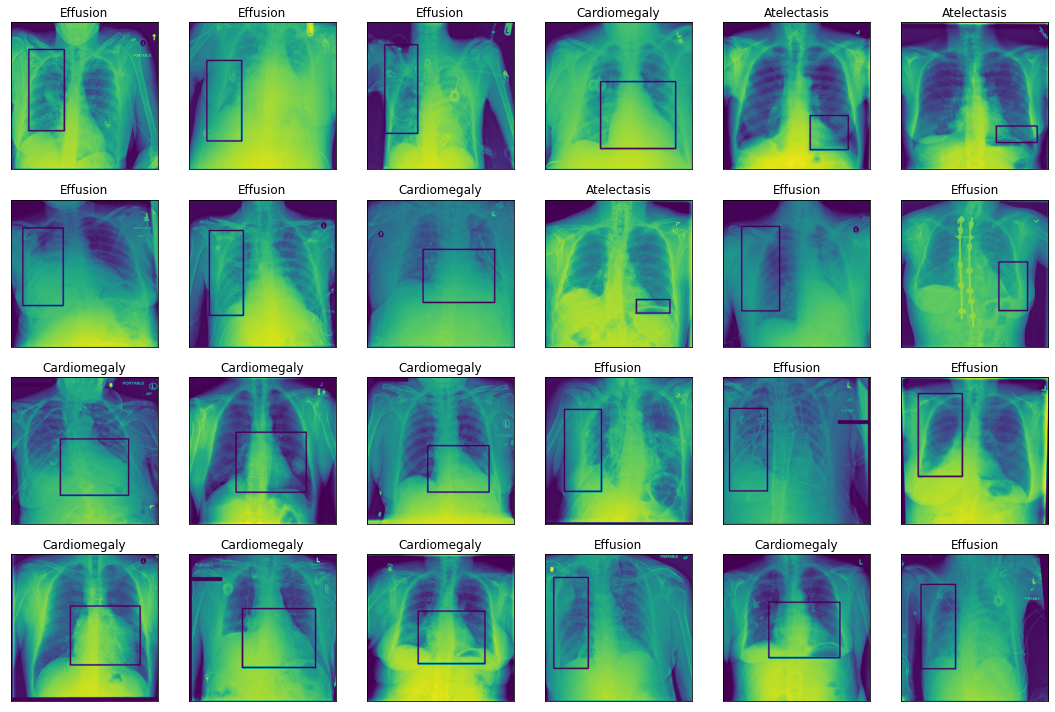

In [80]:
print("Object Detections in Chest X-Ray (Prediction for Test Data)")
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img, _ = test[i]

    img = img.numpy()

    img = np.transpose(img, (1, 2, 0))
    
            
    scores = []
    boxes = []
    names = []
    for j, box in enumerate(predictions[i]["boxes"]):
        score = predictions[i]["scores"][j].cpu().detach().numpy()
        scores.append(score)

        if score == max(scores):
            boxes.append(box.cpu().tolist())
            label = predictions[i]["labels"][j].item()
            if label >= len(index2name):
                label = 0
            name = index2name[label]
            names.append(name)
    boxes = torch.tensor(boxes)
    
    if names != []:

        cv2.rectangle(img, (int(boxes[0][0].item()),\
                            int(boxes[0][1].item())),\
                      (int(boxes[0][2].item()),\
                       int(boxes[0][3].item())),\
                      (0, 0, 0), 10)

    ax.imshow(img)
    
    if names != []:
        ax.set_title(names[0])
    else:
        ax.set_title("No Finding")

fig.tight_layout()    

plt.show()

Object Detections in Chest X-Ray (Prediction for Test Data)


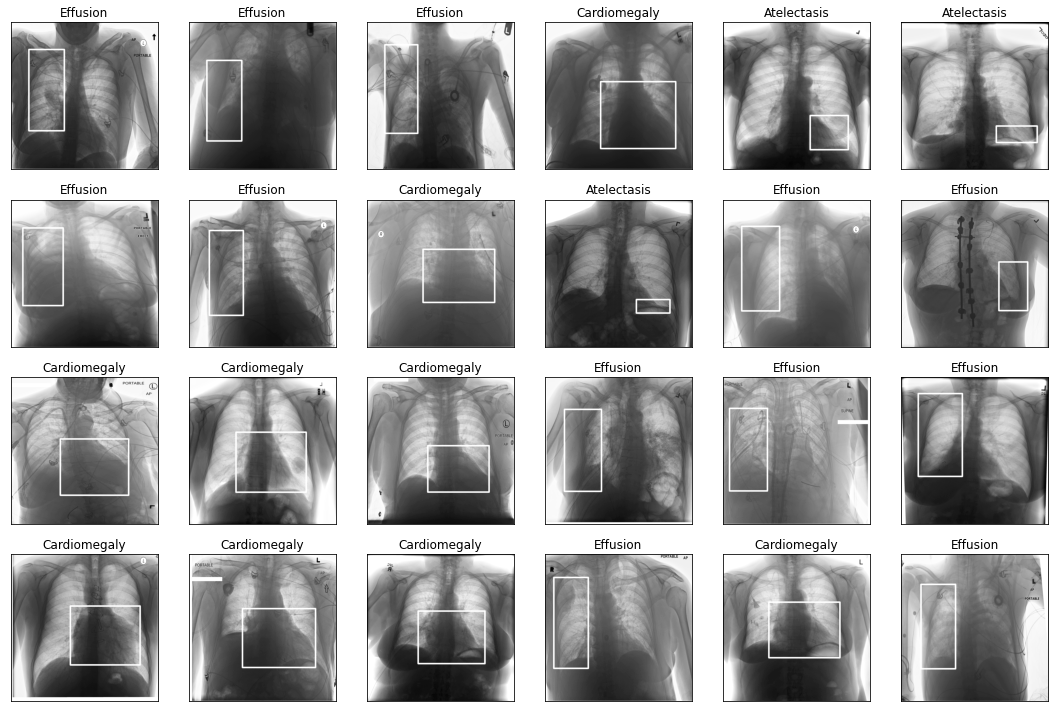

In [81]:
print("Object Detections in Chest X-Ray (Prediction for Test Data)")
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img, _ = test[i]

    img = img.numpy()

    img = np.transpose(img, (1, 2, 0))
    
            
    scores = []
    boxes = []
    names = []
    for j, box in enumerate(predictions[i]["boxes"]):
        score = predictions[i]["scores"][j].cpu().detach().numpy()
        scores.append(score)

        if score == max(scores):
            boxes.append(box.cpu().tolist())
            label = predictions[i]["labels"][j].item()
            if label >= len(index2name):
                label = 0
            name = index2name[label]
            names.append(name)
    boxes = torch.tensor(boxes)
    
    if names != []:

        cv2.rectangle(img, (int(boxes[0][0].item()),\
                            int(boxes[0][1].item())),\
                      (int(boxes[0][2].item()),\
                       int(boxes[0][3].item())),\
                      (0, 0, 0), 10)

    ax.imshow(img, cmap = 'gray_r')
    
    if names != []:
        ax.set_title(names[0])
    else:
        ax.set_title("No Finding")

fig.tight_layout()    

plt.show()

# Compare the Prediction with the Truth in the Test Data

Here we **compare the predictions made by the trained model with the truth shown in the test data**.

Object Detections in Chest X-Ray (Truth for Test Data)


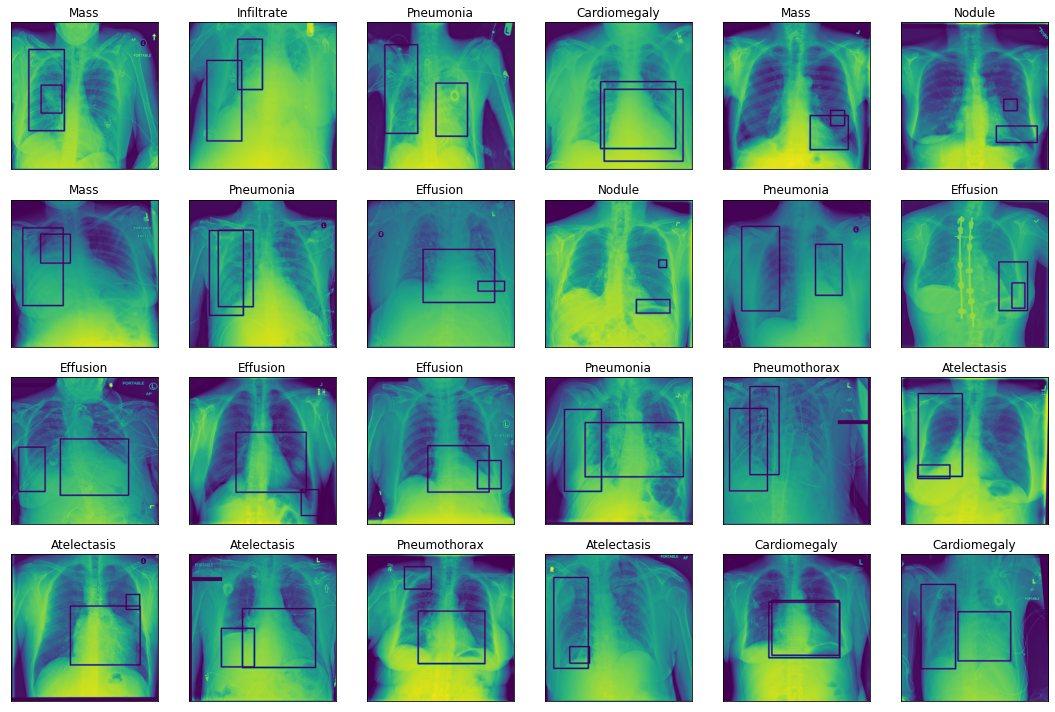

In [82]:
print("Object Detections in Chest X-Ray (Truth for Test Data)")
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img, t = test[i]

    img = img.numpy()

    img = np.transpose(img, (1, 2, 0))
    
    cv2.rectangle(img, (int(t["boxes"][0][0].item()),\
                        int(t["boxes"][0][1].item())),\
                  (int(t["boxes"][0][2].item()),\
                   int(t["boxes"][0][3].item())),\
                  (0, 0, 0), 10)
    

    ax.imshow(img)
    ax.set_title(index2name[int(t["labels"][0].item())])
fig.tight_layout()    

plt.show()

Object Detections in Chest X-Ray (Truth for Test Data)


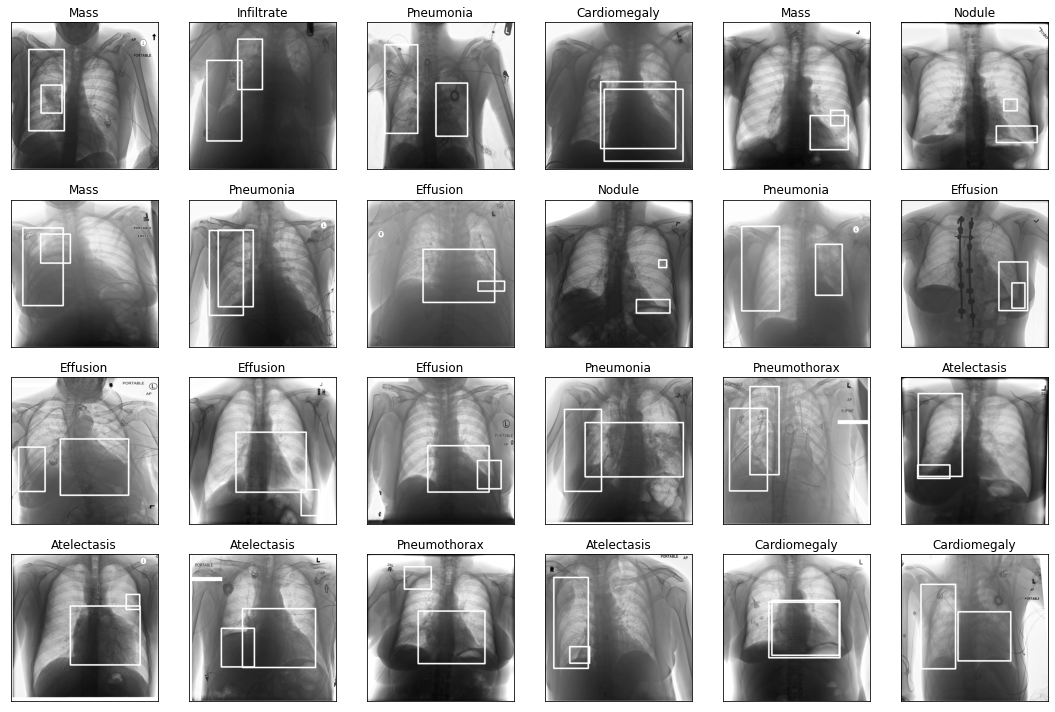

In [83]:
print("Object Detections in Chest X-Ray (Truth for Test Data)")
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img, t = test[i]

    img = img.numpy()

    img = np.transpose(img, (1, 2, 0))
    
    cv2.rectangle(img, (int(t["boxes"][0][0].item()),\
                        int(t["boxes"][0][1].item())),\
                  (int(t["boxes"][0][2].item()),\
                   int(t["boxes"][0][3].item())),\
                  (0, 0, 0), 10)
    

    ax.imshow(img, cmap = 'gray_r')
    ax.set_title(index2name[int(t["labels"][0].item())])
fig.tight_layout()    

plt.show()

In [84]:
dataiter = iter(test_loader)
image, target = next(dataiter)
print(target)

print(image)

{'boxes': tensor([[[209.1344, 439.9407, 355.4201, 634.9883]],

        [[339.1661, 119.1958, 511.4582, 470.2815]],

        [[480.0339, 425.8540, 700.0042, 795.3608]],

        [[412.8508, 468.1143, 961.1513, 969.8201]],

        [[749.2267, 615.8602, 847.0756, 722.8113]],

        [[711.9238, 537.4645, 804.0296, 618.7344]],

        [[206.9672, 237.3079, 413.9344, 439.9407]],

        [[203.0933, 209.6735, 447.7155, 743.2913]],

        [[773.1200, 565.7979, 958.5778, 634.0646]],

        [[792.1100, 417.1852, 847.3735, 470.2815]],

        [[644.7407, 308.8254, 830.0359, 663.1619]],

        [[767.1873, 577.5577, 857.1259, 753.1005]],

        [[ 53.0963, 488.7026, 237.3079, 797.5280]],

        [[781.2740, 784.5248, 905.8878, 965.4857]],

        [[769.3545, 581.8921, 934.0614, 778.0233]],

        [[279.3244, 317.7624, 963.1289, 695.5046]],

        [[187.1644,  66.3135, 390.8267, 680.7135]],

        [[115.9450, 612.2328, 338.0826, 706.5058]],

        [[802.9460, 281.7354, 896.13

In [85]:
"""
for i in range(24):
    print(f"Image{i}")
    dataiter = iter(test_loader)
    image, target = next(dataiter)

    image = image[i]
    image = (image * 255).to(torch.uint8) 

    boxes = target["boxes"][i]

    labels = target["labels"][i]
    names = [index2name[label.item()] for label in labels]

    show_boxes(image, boxes, names)
"""

'\nfor i in range(24):\n    print(f"Image{i}")\n    dataiter = iter(test_loader)\n    image, target = next(dataiter)\n\n    image = image[i]\n    image = (image * 255).to(torch.uint8) \n\n    boxes = target["boxes"][i]\n\n    labels = target["labels"][i]\n    names = [index2name[label.item()] for label in labels]\n\n    show_boxes(image, boxes, names)\n'

# Calculate Mean Average Precision (mAP)

The code provided below is **making predictions using the fine-tuned RetinaNet model on the test dataset and visualizing the predicted bounding boxes and labels**. Here's a breakdown of the code:

    1. Extracting images and targets from the test data loader:
    
        The iter() function is used to create an iterator from the test_loader.
        
        The next() function is used to get the next batch of data from the iterator, returning images and target.

    2. Moving the images to the GPU:
    
        The images tensor is moved to the GPU using the cuda() method.

    3. Setting the model to evaluation mode:
    
        The model.eval() method is called to set the model to evaluation mode, disabling gradient calculations and batch normalization.

    4. Making predictions on the test images:
    
        Inside the torch.no_grad() context, the model is called with the images tensor to obtain the predictions.
        
        The predictions contain bounding box coordinates and class labels.

    5. Printing the predictions:
    
        The predictions are printed to the console using print(predictions).

    6. Preparing the image for visualization:
    
        The first image from the batch is selected using index [0].
        
        The pixel values in the image are multiplied by 255 and cast to torch.uint8 to convert them to the expected range for image visualization.
        
        The image tensor is moved to the CPU using the cpu() method.

    7. Extracting the bounding boxes, labels, and names from the predictions:
    
        The bounding boxes are extracted from predictions[0]["boxes"] and moved to the CPU using the cpu() method.
        
        The labels are extracted from predictions[0]["labels"], converted to a NumPy array, and clipped to the range of valid class indices.
        
        The class names are retrieved from index2name using the class labels.

    8. Printing the predicted class names:
    
        The predicted class names are printed using print(names).

    9. Calling show_boxes() to display the image with predicted bounding boxes and labels:
    
        The preprocessed image, bounding boxes, and class names are passed as arguments to the show_boxes() function.

This code segment demonstrates how to make predictions using the fine-tuned RetinaNet model on the test dataset and visualize the results using the show_boxes() function.

In [86]:
boxes = []
scores = []
labels = []
for i in range(24):
    all_scores = []
    for j, box in enumerate(predictions[i]["boxes"]):
        score = predictions[i]["scores"][j].cpu().detach().numpy()
        all_scores.append(score)

        if score == max(all_scores):
            score = torch.tensor(score).item()
            scores.append(score)
            boxes.append(box.cpu().tolist())
            label = predictions[i]["labels"][j].item()
            if label >= len(index2name):
                label = 0
            labels.append(label)

print(boxes)
print(scores)
print(labels)

[[124.12498474121094, 191.65005493164062, 371.3324890136719, 757.6123046875], [124.93468475341797, 267.26849365234375, 367.10546875, 828.1323852539062], [124.46414947509766, 158.5586700439453, 353.5072326660156, 775.8152465820312], [387.360107421875, 415.23956298828125, 910.6393432617188, 881.9854736328125], [607.0662231445312, 651.7813720703125, 872.7529296875, 889.1477661132812], [659.3364868164062, 724.1183471679688, 942.2009887695312, 839.5850830078125], [82.85891723632812, 194.512939453125, 363.9877014160156, 735.00146484375], [141.54238891601562, 212.46649169921875, 378.3414001464844, 803.4405517578125], [390.4413146972656, 343.0946350097656, 889.1279296875, 713.2823486328125], [636.8154907226562, 693.8998413085938, 870.1619262695312, 787.7035522460938], [130.91929626464844, 183.2965850830078, 394.08599853515625, 772.0286254882812], [677.6644897460938, 431.2191162109375, 876.0433959960938, 770.6134033203125], [343.2967224121094, 431.8140869140625, 819.4959716796875, 823.882629394

In [87]:
preds = [
  dict(
    boxes = torch.tensor(boxes),
    scores = torch.tensor(scores),
    labels = torch.tensor(labels),
  )
]

In [88]:
dataiter = iter(test_loader)
_, target = next(dataiter)
print(target["boxes"].squeeze(1))
print(target["labels"].squeeze(1))

tensor([[209.1344, 439.9407, 355.4201, 634.9883],
        [339.1661, 119.1958, 511.4582, 470.2815],
        [480.0339, 425.8540, 700.0042, 795.3608],
        [412.8508, 468.1143, 961.1513, 969.8201],
        [749.2267, 615.8602, 847.0756, 722.8113],
        [711.9238, 537.4645, 804.0296, 618.7344],
        [206.9672, 237.3079, 413.9344, 439.9407],
        [203.0933, 209.6735, 447.7155, 743.2913],
        [773.1200, 565.7979, 958.5778, 634.0646],
        [792.1100, 417.1852, 847.3735, 470.2815],
        [644.7407, 308.8254, 830.0359, 663.1619],
        [767.1873, 577.5577, 857.1259, 753.1005],
        [ 53.0963, 488.7026, 237.3079, 797.5280],
        [781.2740, 784.5248, 905.8878, 965.4857],
        [769.3545, 581.8921, 934.0614, 778.0233],
        [279.3244, 317.7624, 963.1289, 695.5046],
        [187.1644,  66.3135, 390.8267, 680.7135],
        [115.9450, 612.2328, 338.0826, 706.5058],
        [802.9460, 281.7354, 896.1354, 386.8445],
        [225.0847, 517.7311, 455.0508, 786.7480],


In [89]:
target = [
  dict(
    boxes = target["boxes"].squeeze(1),
    labels = target["labels"].squeeze(1),
  )
]

To calculate the mean average precision (mAP) for object detection, the code provided below utilizes the MeanAveragePrecision class from torchmetrics.detection. Here's a breakdown of the code:

1. Importing the necessary module and class:

    The MeanAveragePrecision class is imported from torchmetrics.detection.mean_ap.
    
    The pprint function is imported from the pprint module.

2. Creating an instance of the MeanAveragePrecision class:

    The MeanAveragePrecision class is instantiated with the following arguments:
    
        task="multiclass": Specifies that the task is multiclass object detection.
        
        num_classes=9: Specifies **the number of classes** (assuming 9 in this case).
        
        average=None: Specifies that individual average precision scores should be computed for each class separately.

3. Updating the metric with predictions and targets:

    The update() method of the metric object is called to update the metric with the predictions (preds) and ground truth targets (target).

4. Computing the mean average precision:

    The compute() method of the metric object is called to compute the mean average precision.
    
    The pprint() function is used to pretty print the computed metric, displaying the average precision scores for each class separately.

By using the MeanAveragePrecision class from torchmetrics.detection, we can easily calculate the mAP metric for multiclass object detection tasks.

In [90]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
metric = MeanAveragePrecision(task = "multiclass", num_classes = 9, average = None)
metric.update(preds, target)
from pprint import pprint
pprint(metric.compute())

{'map': tensor(0.0410),
 'map_50': tensor(0.1145),
 'map_75': tensor(0.0070),
 'map_large': tensor(0.0468),
 'map_medium': tensor(0.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.0083),
 'mar_10': tensor(0.0708),
 'mar_100': tensor(0.0708),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.0810),
 'mar_medium': tensor(0.),
 'mar_small': tensor(-1.)}


# Save the Model

Save the trained model to use it later for this or another notebook.

In [91]:
torch.save(model, 'object_detection_chestxray_pred_model.pth')

In [92]:
saved_model = torch.load('/kaggle/working/object_detection_chestxray_pred_model.pth')

In [93]:
saved_model

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


# Conclusion

**The results did not appear to be sufficient to detect an object in Chest X-ray properly. Object detection in Chest X-ray is a difficult task. Furthermore, the number of medical data is not sufficient to train the model at a satisfactional level.**

It is also expected that object detection can be used for different medical images to detect various medical findings.

I am a medical doctor working on **artificial intelligence (AI) for medicine**. At present AI is also widely used in the medical field. Particularly, AI performs in the healthcare sector following tasks: **image classification, object detection, semantic segmentation, GANs, text classification, etc**. **If you are interested in AI for medicine, please see my other notebooks.**